#2 Run
This file takes in the file written as a .csv from naive.ipynb. The output is used by compare.ipynb

In [304]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import numpy as np
#from arch import arch_model

In [305]:
def read_file(file):
    """Read a single file and return a dataframe"""
    return pd.read_csv(file, skipinitialspace=True)

In [306]:
garch = False
rolling_avg = False
implied_vol = False
test_pq = False
iv_surface = True

In [307]:
import pandas as pd

if implied_vol or iv_surface:
    file = '../data/processed_data/2010-2023_NSS_filtered_with_IV.csv'
    df_IV = pd.read_csv(file, skipinitialspace=True)
    df_IV = df_IV[df_IV["Quote_date"] >= "2014-11-01"]
    print("Length of df_IV", len(df_IV))
    file = '../data/processed_data/2010-2023_NSS_filtered_vF.csv'
    df = pd.read_csv(file, skipinitialspace=True)
    df = df[df["Quote_date"] >= "2014-11-01"]
    print("Length of df", len(df))


Length of df_IV 8607465
Length of df 10654942


# Volatility

### GARCH

In [308]:
if test_pq:
    # Assuming your dataframe is named `df`
    df_unique_dates = df[['Quote_date', 'Underlying_last']].drop_duplicates()

    df_unique_dates['log_returns'] = np.log(df_unique_dates['Underlying_last']) - np.log(df_unique_dates['Underlying_last'].shift(1))
    df_unique_dates = df_unique_dates[['Quote_date', 'log_returns']].dropna()

    # Define a function to fit GARCH models and return AIC and BIC
    def fit_garch_aic_bic(log_returns, p, q):
        model = arch_model(log_returns, vol='Garch', p=p, q=q, dist='Normal')
        results = model.fit(disp='off')
        return results.aic, results.bic

    # Test GARCH models with different p and q values
    pq_values = [(1, 1), (1, 2), (2, 1), (2, 2), (1, 3), (3, 1), (2, 3), (3, 2), (3, 3), (4, 1), (1, 4), (4, 2), (2, 4), (4, 4)]

    aic_bic_values = [fit_garch_aic_bic(df_unique_dates['log_returns'], p, q) for p, q in pq_values]
    aic_values, bic_values = zip(*aic_bic_values)

    # Find the best p and q values based on AIC and BIC
    best_pq_aic = pq_values[np.argmin(aic_values)]
    best_pq_bic = pq_values[np.argmin(bic_values)]
    print(f"Best GARCH model based on AIC: GARCH({best_pq_aic[0]},{best_pq_aic[1]})")
    print(f"Best GARCH model based on BIC: GARCH({best_pq_bic[0]},{best_pq_bic[1]})")


In [309]:
if garch:
    df_unique_dates = df[['Quote_date', 'Underlying_last']].drop_duplicates()

    df_unique_dates['log_returns'] = np.log(df_unique_dates['Underlying_last']) - np.log(df_unique_dates['Underlying_last'].shift(1))
    df_unique_dates = df_unique_dates[['Quote_date', 'log_returns']].dropna()

    # Define GARCH(1,1) model
    model = arch_model(df_unique_dates['log_returns'], vol='Garch', p=1, q=1, dist='Normal')

    # Fit the model
    results = model.fit(update_freq=5)

    # Predict the volatility (annualized)
    df_unique_dates['predicted_volatility'] =  results.conditional_volatility * np.sqrt(252)

    # Merge the predicted volatility with the original dataframe
    df = df.merge(df_unique_dates[['Quote_date', 'predicted_volatility']], on='Quote_date', how='left')

    df = df[df["Quote_date"] >= "2015-01-01"]
    # Drop rows with NaN values
    df = df.dropna()



### Rolling average

In [310]:
if rolling_avg:    
    # Add volatility column with 30 day rolling standard deviation of Underlying_last

    # New dataframe without duplicate Quote_dates
    df2 = df.drop_duplicates(subset=['Quote_date'])

    # Calculate volatility
    df2['rolling_volatility'] = np.log(df2["Underlying_last"] / df2["Underlying_last"].shift()).rolling(30).std()*(252**0.5)

    # Matching volatility in df2 to df
    df['rolling_volatility'] = df['Quote_date'].map(df2.set_index('Quote_date')['rolling_volatility'])

    df = df[df["Quote_date"] >= "2015-01-01"]

    # Drop rows with NaN values
    df = df.dropna()

### Implied vol

In [311]:
# Black-Scholes formula for call options
def d1(S,K,T,r,sigma):
    x1 = S.apply(lambda x : log(x)) - K.apply(lambda x : log(x))
    x2 = (r + ((sigma.apply(lambda x : x**2)) / 2)) * T
    x3 = sigma * T.apply(lambda x: sqrt(x))
    return  (x1 + x2) / x3

def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma) - sigma * T.apply(lambda x : sqrt(x))  

def bs_call(S,K,T,r,sigma):
    return S * d1(S,K,T,r,sigma).apply(lambda x : norm.cdf(x)) - K * (-r*T).apply(lambda x : exp(x)) * d2(S,K,T,r,sigma).apply(lambda x : norm.cdf(x))

In [312]:
if implied_vol:    
    # Calculate the average implied volatility for each date
    avg_implied_vol_df = df_IV.groupby(
        'Quote_date')['IV'].median().reset_index()

    # Add a new column with the average implied volatility shifted by one row
    avg_implied_vol_df['avg_implied_vol_t-1'] = avg_implied_vol_df['IV'].shift(1)

    # Merge the avg_implied_vol_df DataFrame back to the original df DataFrame
    df = df.merge(avg_implied_vol_df[[
        'Quote_date', 'avg_implied_vol_t-1']], on='Quote_date', how='left')

    # Drop rows with NaN values
    df = df.dropna()


In [313]:
if iv_surface:
    num_moneyness_buckets = 20
    num_ttm_buckets = 20

    # If df_IV["IV"] < 0 or nan, drop it
    df_IV = df_IV[df_IV["IV"] > 0]

    df['Moneyness'] = df['Underlying_last'] / df['Strike']
    print("Length of df: ", len(df))
    df_IV['Moneyness'] = df_IV['Underlying_last'] / df_IV['Strike']

    # Calculate the moneyness and TTM bucket thresholds using df_IV
    moneyness_thresholds = pd.qcut(df_IV['Moneyness'], num_moneyness_buckets, retbins=True, duplicates='drop')[1]
    moneyness_thresholds = np.concatenate([[-np.inf], moneyness_thresholds[1:-1], [np.inf]])
    ttm_thresholds = pd.qcut(df_IV['TTM'], num_ttm_buckets, retbins=True, duplicates='drop')[1]

    # Apply the same moneyness and TTM bucket thresholds to both DataFrames
    df['moneyness_bucket'] = pd.cut(df['Moneyness'], bins=moneyness_thresholds, labels=False, include_lowest=True)
    df['ttm_bucket'] = pd.cut(df['TTM'], bins=ttm_thresholds, labels=False, include_lowest=True)
    df_IV['moneyness_bucket'] = pd.cut(df_IV['Moneyness'], bins=moneyness_thresholds, labels=False, include_lowest=True)
    df_IV['ttm_bucket'] = pd.cut(df_IV['TTM'], bins=ttm_thresholds, labels=False, include_lowest=True)

    # Calculate the average implied volatility for each date and bucket combination
    avg_implied_vol_surface = df_IV.groupby(
        ['Quote_date', 'moneyness_bucket', 'ttm_bucket'])['IV'].mean().reset_index()
    
    avg_implied_vol_surface['implied_vol_t-1'] = avg_implied_vol_surface.groupby(
        ['moneyness_bucket', 'ttm_bucket'])['IV'].shift(1)
    
    # Merge the avg_implied_vol_surface DataFrame back to the original df DataFrame
    df = df.merge(avg_implied_vol_surface[[
        'Quote_date', 'moneyness_bucket', 'ttm_bucket', 'implied_vol_t-1']],
        on=['Quote_date', 'moneyness_bucket', 'ttm_bucket'], how='left')
    
    print("Number of nan", df['implied_vol_t-1'].isna().sum())

    df['implied_vol_t-1'] = df.groupby(['moneyness_bucket', 'ttm_bucket'])['implied_vol_t-1'].fillna(method='bfill')
    
    print("Number of nan", df['implied_vol_t-1'].isna().sum())
    
    # Print nan count for each column
    df = df[df["Quote_date"] >= "2015-01-01"]
    print(df.isna().sum())
    #df = df.dropna()

    print("Length of df: ", len(df))

Length of df:  10654942
Unnamed: 0          0
Quote_date          0
Price               0
Underlying_last     0
Strike              0
TTM                 0
R                   0
Moneyness           0
moneyness_bucket    0
ttm_bucket          0
implied_vol_t-1     0
dtype: int64
Length of df:  10539487


In [314]:
display(df)

,Unnamed: 0,Quote_date,Price,Underlying_last,Strike,TTM,R,Moneyness,moneyness_bucket,ttm_bucket,implied_vol_t-1
115455,1809055,2015-01-02,1007.250,2058.69,1050.0,0.019178,0.00020,1.960657,19,1,1.014561
115456,1809056,2015-01-02,957.095,2058.69,1100.0,0.019178,0.00020,1.871536,19,1,1.014561
115457,1809057,2015-01-02,907.140,2058.69,1150.0,0.019178,0.00020,1.790165,19,1,1.014561
115458,1809058,2015-01-02,882.150,2058.69,1175.0,0.019178,0.00020,1.752077,19,1,1.014561
115459,1809059,2015-01-02,857.150,2058.69,1200.0,0.019178,0.00020,1.715575,19,1,1.014561
...,...,...,...,...,...,...,...,...,...,...,...
10654937,13739049,2023-03-31,217.750,4109.88,4700.0,1.726027,0.04198,0.874443,1,19,0.174798
10654938,13739050,2023-03-31,180.000,4109.88,4800.0,1.726027,0.04198,0.856225,0,19,0.164947
10654939,13739051,2023-03-31,146.550,4109.88,4900.0,1.726027,0.04198,0.838751,0,19,0.164947
10654940,13739052,2023-03-31,118.200,4109.88,5000.0,1.726027,0.04198,0.821976,0,19,0.164947


In [315]:
if False:
    df = df_read.copy()
    # Filter out options with a difference in strike price of more than 4% from the underlying price and a TTM of less than 20 days
    df = df[(df['Underlying_last'] > df['Strike'] * 0.94) & (df['Underlying_last'] < df['Strike'] * 1.06) & (df['TTM'] > 15)]

    from py_vollib.black_scholes import black_scholes as bs
    from py_vollib.black_scholes.greeks.analytical import vega
    import matplotlib.pyplot as plt

    def implied_vol(S0, K, T, r, market_price, flag='c', tol=0.000001):
        """Compute the implied volatility of a European Option
            S0: initial stock price
            K:  strike price
            T:  maturity
            r:  risk-free rate
            market_price: market observed price
            tol: user choosen tolerance
        """
        T = T/365 #converting to years
        r = r/100
        max_iter = 200 #max number of iterations
        vol_old = 0.20 #initial guess
        for k in range(max_iter):
            bs_price = bs(flag, S0, K, T, r, vol_old)
            Cprime =  vega(flag, S0, K, T, r, vol_old)*100
            C = bs_price - market_price
            vol_new = vol_old - C/Cprime
            bs_new = bs(flag, S0, K, T, r, vol_new)
            if (abs(vol_old - vol_new) < tol or abs(bs_new - market_price) < tol):
                break
            vol_old = vol_new
        implied_vol = vol_old
        return implied_vol
    

    # Add implied volatility column
    df['Implied_volatility'] = df.apply(lambda x: implied_vol(x['Underlying_last'], x['Strike'], x['TTM'], x['R'], x['Price'], 'c'), axis=1)

    display(df)
    print("Number of rows with NaN values: ", df.isna().sum().sum())
    df = df.dropna()

    # Calculate the average implied volatility for each date
    avg_implied_vol_df = df.groupby('Quote_date')['Implied_volatility'].mean().reset_index()

    # Add a new column with the average implied volatility shifted by one row
    avg_implied_vol_df['avg_implied_vol_t-1'] = avg_implied_vol_df['Implied_volatility'].shift(1)

    # Merge the avg_implied_vol_df DataFrame back to the original df DataFrame
    df = df.merge(avg_implied_vol_df[['Quote_date', 'avg_implied_vol_t-1']], on='Quote_date', how='left')
    

In [316]:
if False:
    df = df_read.copy()
    import numpy as np
    from scipy.stats import norm

    def bs_call(S, K, T, r, vol):
        eps = 1e-8
        d1 = np.divide((np.log(S/K) + (r + 0.5*vol**2)*T), (vol*np.sqrt(T) + eps))
        d2 = d1 - vol * np.sqrt(T)
        return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

    def bs_vega(S, K, T, r, sigma):
        eps = 1e-8
        d1 = np.divide((np.log(S/K) + (r + 0.5*sigma**2)*T), (sigma*np.sqrt(T) + eps))
        return S * norm.pdf(d1) * np.sqrt(T)

    def find_vol(target_values, S, K, T, r):
        MAX_ITERATIONS = 200
        PRECISION = 1.0e-5
        sigmas = np.full_like(target_values, 0.5)

        for _ in range(MAX_ITERATIONS):
            prices = bs_call(S, K, T, r, sigmas)
            vegas = bs_vega(S, K, T, r, sigmas)
            diffs = target_values - prices

            mask = np.abs(diffs) >= PRECISION
            if not np.any(mask):
                break

            sigmas[mask] += np.divide(diffs[mask], vegas[mask], out=np.full_like(diffs[mask], np.nan), where=(vegas[mask] != 0))

        return sigmas


    df['Implied_volatility'] = find_vol(df['Price'].values, df['Underlying_last'].values, df['Strike'].values, df['TTM'].values, df['R'].values)


    len_before = len(df)
    df = df.dropna()
    len_after = len(df)
    print(f"Number of rows dropped: {len_before - len_after}, which is {round((len_before - len_after)/len_before*100, 2)}% of the original dataframe")

    # Calculate the average implied volatility for each date
    avg_implied_vol_df = df.groupby('Quote_date')['Implied_volatility'].mean().reset_index()

    # Add a new column with the average implied volatility shifted by one row
    avg_implied_vol_df['avg_implied_vol_t-1'] = avg_implied_vol_df['Implied_volatility'].shift(1)

    # Merge the avg_implied_vol_df DataFrame back to the original df DataFrame
    df = df.merge(avg_implied_vol_df[['Quote_date', 'avg_implied_vol_t-1']], on='Quote_date', how='left')

# BS

In [317]:
if rolling_avg:
    df["Volatility"] = df["rolling_volatility"]
if garch:
    df["Volatility"] = df["predicted_volatility"]
if implied_vol:
    df["Volatility"] = df["avg_implied_vol_t-1"]
if iv_surface:
    df["Volatility"] = df["implied_vol_t-1"]
print(len(df))
df["BS"] = bs_call(df["Underlying_last"], df["Strike"], df["TTM"], df["R"], df["Volatility"])
print(len(df))
df = df[df["Quote_date"] >= "2015-01-01"]
print(len(df))

10539487


In [ ]:
print("RMSE for full period", np.sqrt(np.mean((df['BS'] - df['Price'])**2)))

RMSE for full period 20.71868556588252


In [ ]:
display(df.sample(100))

,Unnamed: 0,Quote_date,Price,Underlying_last,Strike,TTM,R,Moneyness,moneyness_bucket,ttm_bucket,implied_vol_t-1,Volatility,BS
5085182,7007442,2019-09-06,0.145,2978.83,3210.0,0.065753,0.020500,0.927984,2.0,6,0.113462,0.113462,0.167976
2911757,4652895,2017-12-11,47.600,2659.94,2875.0,1.104110,0.017156,0.925197,2.0,19,0.119261,0.119261,71.141534
8052495,10433248,2021-08-20,214.700,4441.31,4475.0,0.610959,0.000440,0.992472,7.0,17,0.180239,0.180239,234.415294
8160988,10558362,2021-09-16,1106.855,4474.05,3475.0,1.747945,0.001812,1.287496,18.0,19,0.270949,0.270949,1204.921795
5759416,7732576,2020-02-25,4.845,3128.30,3565.0,0.345205,0.014984,0.877504,1.0,15,0.121557,0.121557,3.777300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091010,4846343,2018-02-13,325.245,2662.95,2340.0,0.027397,0.013400,1.138013,15.0,2,0.452845,0.452845,326.988380
3720570,5528537,2018-08-20,0.125,2856.98,2970.0,0.019178,0.019300,0.961946,4.0,1,0.125489,0.125489,0.239585
1831775,3468924,2016-10-06,0.095,2160.87,2215.0,0.016438,0.002600,0.975562,5.0,1,0.092613,0.092613,0.177509
9910913,12592824,2022-09-01,608.650,3968.05,3360.0,0.041096,0.025300,1.180967,16.0,3,0.588399,0.588399,627.372167


## Write to file

In [ ]:
# Write to file
df.to_csv('../data/predictions/BS_IV_surface2.csv', encoding='utf-8', index=False)

In [ ]:
# Print first and last date
print("First date:", df["Quote_date"].min())
print("Last date:", df["Quote_date"].max())

First date: 2015-01-02
Last date: 2023-03-31


## Plots

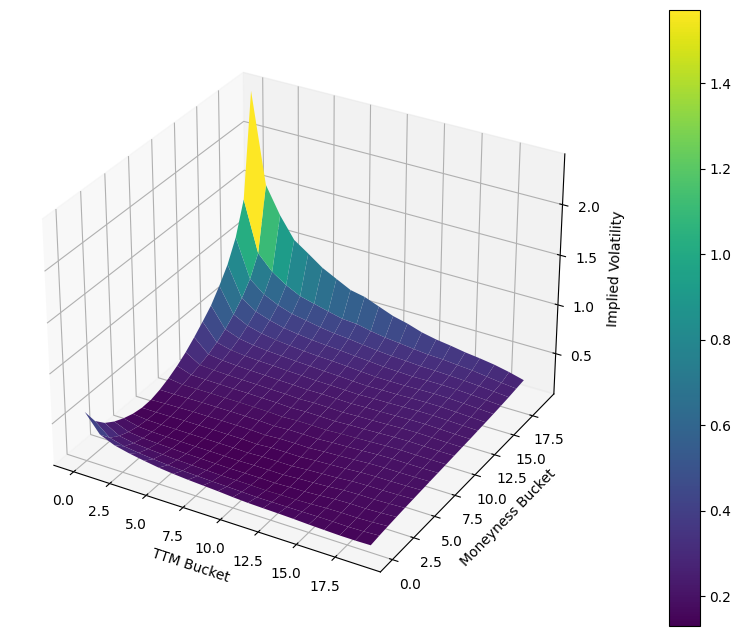

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Group the data by moneyness_bucket, ttm_bucket, and avg_implied_vol_t-1
grouped_data = df.groupby(['moneyness_bucket', 'ttm_bucket'])['implied_vol_t-1'].mean().reset_index()

# Pivot the DataFrame
pivot_table = grouped_data.pivot_table(values='implied_vol_t-1', index='moneyness_bucket', columns='ttm_bucket')


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a grid of moneyness and TTM values
x_vals, y_vals = np.meshgrid(pivot_table.columns.values, pivot_table.index.values)

# Plot the surface
surface = ax.plot_surface(x_vals, y_vals, pivot_table.values, cmap='viridis')

# Add labels and a color bar
ax.set_xlabel('TTM Bucket')
ax.set_ylabel('Moneyness Bucket')
ax.set_zlabel('Implied Volatility')
fig.colorbar(surface, ax=ax, pad=0.1)

# Show the plot
plt.show()

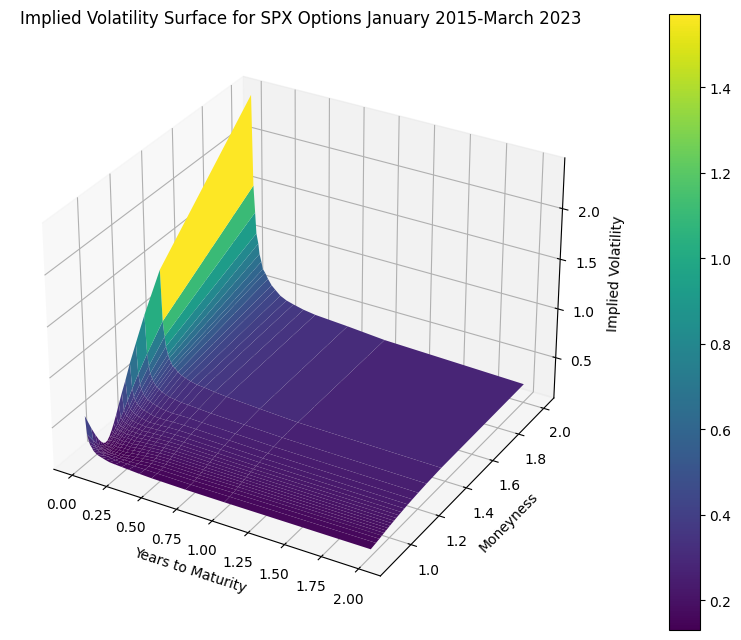

In [ ]:
median_moneyness = df.groupby('moneyness_bucket')['Moneyness'].max().reset_index(name='median_moneyness')
median_ttm = df.groupby('ttm_bucket')['TTM'].max().reset_index(name='median_ttm')
grouped_data = grouped_data.merge(median_moneyness, on='moneyness_bucket')
grouped_data = grouped_data.merge(median_ttm, on='ttm_bucket')
pivot_table = grouped_data.pivot_table(values='implied_vol_t-1', index='median_moneyness', columns='median_ttm')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x_vals, y_vals = np.meshgrid(pivot_table.columns.values, pivot_table.index.values)
surface = ax.plot_surface(x_vals, y_vals, pivot_table.values, cmap='viridis')

# Add title
ax.set_title('Implied Volatility Surface for SPX Options January 2015-March 2023')

ax.set_xlabel('Years to Maturity')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Volatility')
fig.colorbar(surface, ax=ax, pad=0.1)

plt.show()